# **Multiclass Classification of X-ray Radiographs with Transfer Learning (DenseNet-169).**

This notebook serves as a self-educational project in which knowledge derived from other projects and documentation from the TensorFlow guidelines is applied to a multiclass classification task of X-ray images.

This only features the initialisation and fine-tuning of the `DenseNet-169` pretrained model. This is to validate each component in the pipeline, i.e., **model initialisation**, **training**, **prediction**, **corresponding functions**. Once validated, these code components can modularised. The experimentation will be tracked with the Weights and Biases (wandb) platform.

The main project in which all models are trained and evaluated on the classification task is in the `PCXR-model-training-and-eval.ipnyb` notebook.

### Required Libraries

In [20]:
import os
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt                # Visualise images

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'       # Suppress TF messages
import tensorflow as tf

print("TensorFlow version : ", tf.__version__)  # Check TF version

# Check TensorFlow is using the GPU -- for local machine:
gpu = tf.config.list_physical_devices('GPU')
print("Num GPUs Available : ", len(gpu))

# Enable memory growth:
tf.config.experimental.set_memory_growth(gpu[0], True)

# Mount Google Drive -- for Colab environment:
# from google.colab import drive
# drive.mount("/content/drive")

TensorFlow version :  2.10.1
Num GPUs Available :  1


### WandB Installation, Login, and Initialisation

In [ ]:
# For Colab environment:
# !pip install wandb

In [26]:
import wandb
%env "WANDB_NOTEBOOK_NAME" "PCXR-transfer-learning-with-densenet-169"

config = dict(
    learning_rate = 0.0001,
    architecture = "DENSENET-169",
    dataset      = "Chest X-Ray Images (Pneumonia)",
    class_names  = ["normal", "bacteria", "virus"],
    num_classes  = 3,
    val_split    = 0.2,
    init_epochs  = 10,  # initial epochs
    fine_epochs  = 30,  # fine-tuning epochs
    batch_size   = 32,
    image_size   = (300, 300),
    dropout_rate = 0.2,
    activation   = "relu"
)

# Start wandb run and instantiate project
wandb.init(
    project="PCXR-project", 
    name="custom-logger-test",
    notes="testing custom metrics through callback",
    config=config
)

env: "WANDB_NOTEBOOK_NAME"="PCXR-transfer-learning-with-densenet-169"


In [6]:
# Configure project root -- for Colab environment:
PROJECT_ROOT = "/content/drive/MyDrive/Projects/Pneumonia-Xray-Classification"

# Convert ipynb notebook to html
# NB_NAME = "PCXR-transfer-learning-with-densenet-169.ipynb"
# NB_DIR = os.path.join(PROJECT_ROOT, "notebooks")
# CURR_NB = os.path.join(NB_DIR, NB_NAME)

# print("Converting", NB_NAME, "to HTML.")

# %pip install nbconvert
# %jupyter nbconvert --to html CURR_NB

### Data Loading

Here, the data is loaded into the environment with the `image_dataset_from_directory` function, which yields batches of images in the form of `tf.data.Dataset`. For this project, the batch size is configured to 32 images, while the dimensions of each image is configured to a (224, 224) shape. Finally, a validation split of 0.2 is configured for the validation set.

The total number of images per class is also computed below, to check for class imbalance. There is a 2:1:1 ratio spread between the classes, which is a relatively balanced dataset. This is important as it determines which evaluation metrics should be implemented to more accurately reflect model performance.

In [4]:
# Configure directories -- for local machine:
TRAIN_DIR = "..\\artifacts\\train"
TEST_DIR = "..\\artifacts\\test"

# Configure directories -- for Colab environment:
# TRAIN_DIR = os.path.join(PROJECT_ROOT, "images/train")
# TEST_DIR = os.path.join(PROJECT_ROOT, "images/test")

# Load in datasets:
print("LOAD : training and validation data set")
train_ds, valid_ds = tf.keras.utils.image_dataset_from_directory(
    directory=TRAIN_DIR,
    label_mode="int",
    class_names=config["class_names"],
    batch_size=config["batch_size"],
    image_size=config["image_size"],
    shuffle=True,
    seed=42,
    validation_split=config["val_split"],
    subset="both")

print("LOAD : testing data set")
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=TEST_DIR,
    label_mode="int",
    class_names=config["class_names"],
    batch_size=config["batch_size"],
    image_size=config["image_size"],
    shuffle=True,
    seed=42,
    subset=None)

LOAD : training and validation data set
Found 4684 files belonging to 3 classes.
Using 3748 files for training.
Using 936 files for validation.
LOAD : testing data set
Found 1172 files belonging to 3 classes.


In [5]:
# Check number of each class of images
for dir in (TRAIN_DIR, TEST_DIR):
    print("In :", dir)
    for pattern in config["class_names"]:
      subdir = os.path.join(dir, pattern)
      print("Number of", pattern, "images:",
            len([entry for entry in os.listdir(subdir)
            if os.path.isfile(os.path.join(subdir, entry))]))

In : ..\artifacts\train
Number of normal images: 1266
Number of bacteria images: 2224
Number of virus images: 1194
In : ..\artifacts\test
Number of normal images: 317
Number of bacteria images: 556
Number of virus images: 299


### Data Exploration

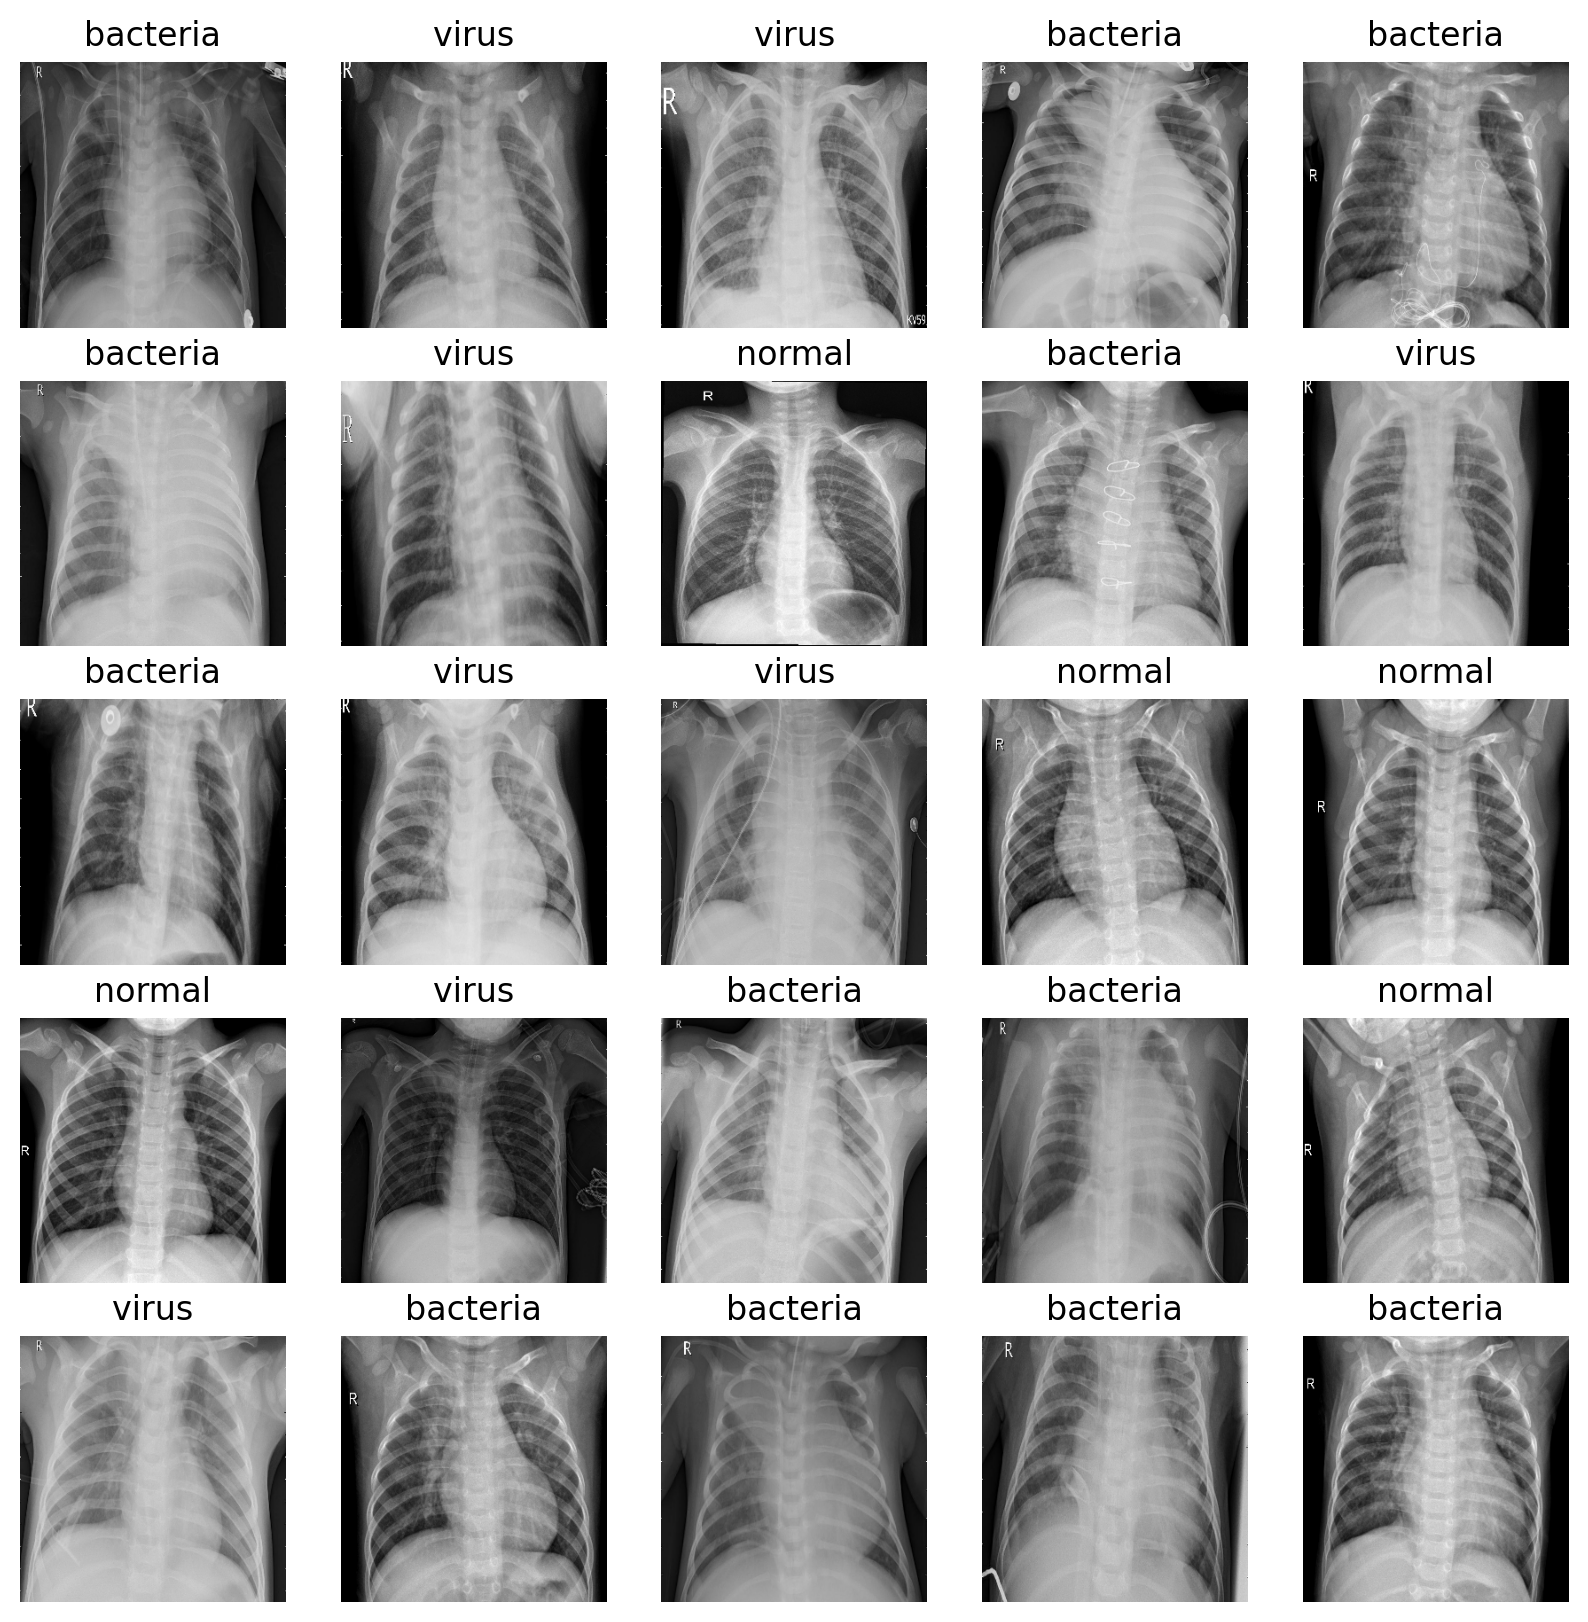

In [26]:
# Configure retina backend for clearer images
%matplotlib inline
%config InlineBackend.figure_format = "retina"

plt.figure(figsize=(10, 10))
for img, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(config["class_names"][labels[i]])
        plt.axis("off")

In [6]:
# Count number of batches for training and validation sets
train_batches = tf.data.experimental.cardinality(train_ds)
valid_batches = tf.data.experimental.cardinality(valid_ds)

print("Number of training batches   : %d" % train_batches)
print("Number of validation batches : %d" % valid_batches)

Number of training batches   : 118
Number of validation batches : 30


### Dataset Configuration for Performance (with prefetching)

Prefetching is configured for both training and validation sets. This overlaps the preprocessing and model execution component in the training phase. During training step `T`, the pipeline is already "prefetching" the next round of data for the subsequent step `T + 1`. This reduces the duration to extract the data during the entire training phase.

The internal buffer, which determines the number of elements to prefetch ahead of when they are requested, is configured to `tf.data.AUTOTUNE`, which prompts the `tf.data` runtime to dynamically tune the value.

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)

### Data Augmentation

In [8]:
# Add an augmentation layer for additional training data
augment_layer = tf.keras.Sequential([
    tf.keras.layers.RandomContrast(factor=0.2, seed=42),
    tf.keras.layers.RandomBrightness(factor=0.2, seed=42),
    tf.keras.layers.RandomRotation(factor=0.01, seed=42)
])

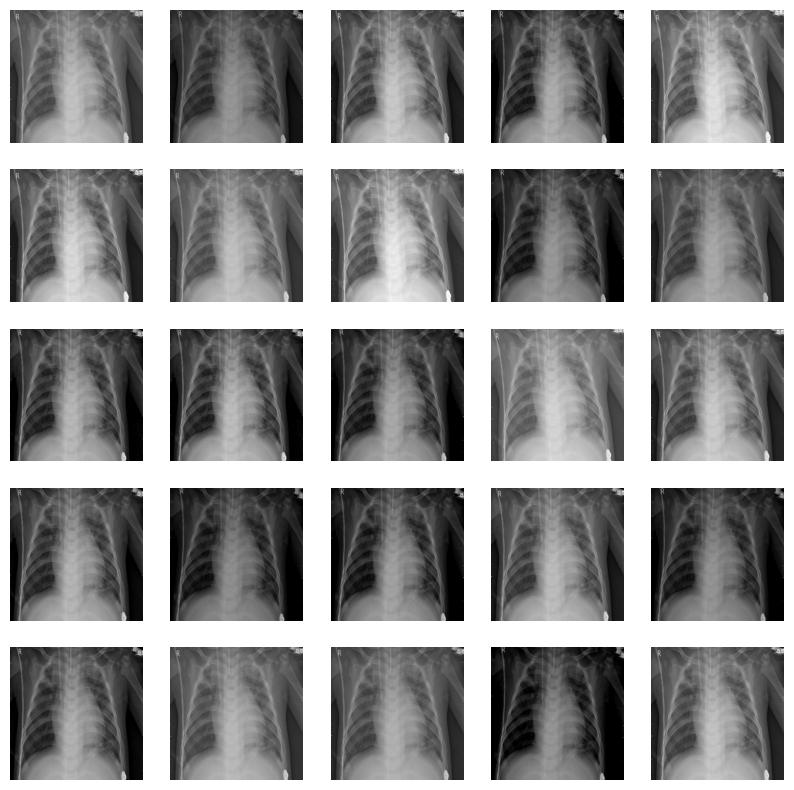

In [11]:
# Check augmented results
for img, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_img = img[0]

for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    aug_img = augment_layer(tf.expand_dims(first_img, 0))
    plt.imshow(aug_img[0] / 255)
    plt.axis('off')

### Model Building (with functional API)

In [9]:
# Configure image shape for model input shape
IMG_SHAPE = config["image_size"] + (3,)

# Instantiate base model
base_model = tf.keras.applications.densenet.DenseNet169(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights="imagenet")

# Freeze convolutional base
base_model.trainable = False

# Instantiate DenseNet preprocessing method
preprocess_input = tf.keras.applications.densenet.preprocess_input

# Check model-extracted feature shape:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print("Output shape following feature extraction:")
print(image_batch.shape, "-->", feature_batch.shape)

# converts each (160, 160, 3) image to a (9, 9, 1664) block of features

Output shape following feature extraction:
(32, 300, 300, 3) --> (32, 9, 9, 1664)


In [27]:
inputs = tf.keras.Input(shape=IMG_SHAPE)

# Establish baseline model:
x = augment_layer(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)    # Prevent training of BN layers

# Add custom classification head:
# x = tf.keras.layers.MaxPooling2D()(x)
# x = tf.keras.layers.Dropout(config["dropout_rate"])(x)  # Prevent overfitting
# x = tf.keras.layers.Conv2D(64, 3,
#                            activation=config["activation"],
#                            input_shape=(1664,))(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dropout(config["dropout_rate"])(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(config["dropout_rate"])(x)

outputs = tf.keras.layers.Dense(config["num_classes"])(x)

# Instantiate model:
model = tf.keras.Model(inputs, outputs)

# Check network architecture:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 300, 300, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 300, 300, 3)      0         
 da)                                                             
                                                           

### Custom Logging Callback

Not enough VRAM.

In [11]:
# Separate validation data to data and labels for custom metric computation
# x_val = np.concatenate([x for x, y in valid_ds], axis=0)
# y_val = np.concatenate([y for x, y in valid_ds], axis=0)

In [28]:
# Create callback to log the following metric scores and write them to WandB:
# import numpy as np
# from sklearn.metrics import f1_score, matthews_corrcoef


# Configure custom log callback:
# class CustomLogCallbackWB(tf.keras.callbacks.Callback):
#     def __init__(self, model, x_val, y_val):
#         super().__init__()
#         self.model = model
#         self.x_val = x_val
#         self.y_val = y_val

#         # Instantiate standalone metrics:
#         self._mcc = tf.keras.metrics.Mean(name="mcc")
#         self._aucroc = tf.keras.metrics.AUC(name="auc")
#         self._f1score = tf.keras.metrics.Mean(name="f1_score")

#         self.epoch = 0

#     def on_epoch_end(self, epoch, logs=None):
#         self.epoch += 1

#         self._mcc.reset_state()
#         self._aucroc.reset_state()
#         self._f1score.reset_state()

#         print("Generating predictions and computing metrics for Epoch {} ".format(self.epoch))
#         predictions = self.model.predict(self.x_val)

#         f1score = f1_score(self.y_val, np.argmax(predictions, axis=-1),
#                             average=None)
#         mcc = matthews_corrcoef(self.y_val, np.argmax(predictions, axis=-1))

#         self._mcc.update_state(mcc)
#         self._f1score.update_state(f1score)
#         self._aucroc.update_state(self.y_val, np.argmax(predictions, axis=-1))

#         print("training loss : {} , training acc : {} , mcc score : {}".format(
#             logs["loss"], logs["accuracy"], self._mcc.result().numpy()
#         ))
#         print("aucroc score  : {} , f1 score     : {} ".format(
#             self._aucroc.result().numpy(), self._f1score.result().numpy()
#         ))

#         # Log metrics to WandB:
#         wandb.log({"mcc": self._mcc.result().numpy(),
#                    "aucroc": self._aucroc.result().numpy(),
#                    "fmeasure": self._f1score.result().numpy()})

## **Model Compilation Phase**

Since the data is not strongly imbalanced, the accuracy score can be used as an evaluation metric.

In [29]:
METRICS = [
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tf.keras.metrics.AUC(name="auc"),
]

# Compile the augmented model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=config["learning_rate"]),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=METRICS
)

## **Model Training Phase**

The model is evaluated initially against the validation dataset to test its effectiveness without training. Unsurprisingly, the model performs poorly. Therefore, the model was trained for ten epochs and evaluated based on the validation accuracy score, which increases gradually through each epoch, indicating that the model is effectively learning from the training images. For better visualisation, learning curves are plotted.

In [30]:
# Evaluate model on validation set without training
eval_loss, eval_accuracy = model.evaluate(valid_ds)

print("initial loss     : {:.2f}".format(eval_loss))
print("initial accuracy : {:.2f}".format(eval_accuracy))

30/30 [==============================] - 12s 285ms/step - loss: 10.3835 - accuracy: 0.2799
initial loss     : 10.38
initial accuracy : 0.28


In [ ]:
# Configure callback:
# custom_log_callback = [CustomLogCallbackWB(model, x_val, y_val)]
wanbd_metrics_callback = [wandb.keras.WandbMetricsLogger()]

# Train model:
model.fit(
    train_ds,
    epochs=config["init_epochs"],
    validation_data=valid_ds,
    callbacks=wanbd_metrics_callback,
    verbose=0
)

In [32]:
# Close WandB run:
wandb.finish()

aucroc,█▁
epoch/accuracy,█▁
epoch/epoch,▁█
epoch/learning_rate,▁▁
epoch/loss,█▁
epoch/val_accuracy,█▁
epoch/val_loss,█▁
fmeasure,█▁
mcc,█▁
aucroc,0.50799
epoch/accuracy,0.39221


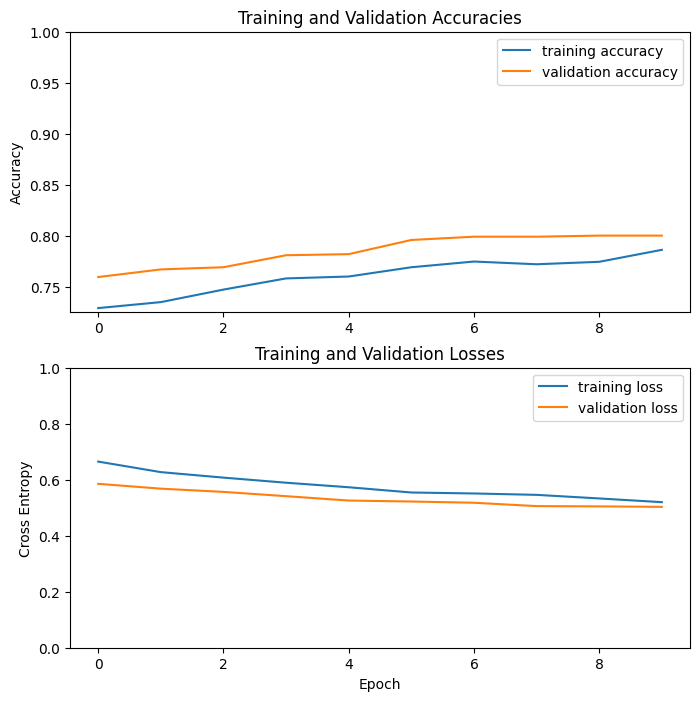

In [ ]:
# Plot the learning curves for training and validation results
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

def plot_learning_curve():

    plt.figure(figsize=(8, 8))

    plt.subplot(2, 1, 1)
    plt.plot(acc, label="training accuracy")
    plt.plot(val_acc, label="validation accuracy")
    plt.legend()
    plt.ylabel("Accuracy")
    plt.ylim([min(plt.ylim()), 1])
    plt.title("Training and Validation Accuracies")

    plt.subplot(2, 1, 2)
    plt.plot(loss, label="training loss")
    plt.plot(val_loss, label="validation loss")
    plt.legend()
    plt.ylabel("Cross Entropy")
    plt.ylim(0, 1.0)
    plt.title("Training and Validation Losses")
    plt.xlabel("Epoch")

    plt.show()

plot_learning_curve()

## **Fine-tuning Phase**

Here, the layers are unfrozen. Only a portion of the model will be configured to trainable. Since the training set is not a large dataset, a smaller number of parameters (only layers after the 500th layer) were unfrozen, to prevent overfitting. Then, the model was compiled with the RMSprop optimiser, which is implemented for its quick convergence times.

In [ ]:
# Unfreeze top layers of model
base_model.trainable = True

# Check base model layers
print("Number of layers in base model:", len(base_model.layers))

In [ ]:
# Freeze all layers before 500 layers
fine_tune_at = 500

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_lr/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])

model.summary()

Number of layers in base model: 595


In [ ]:
fine_tune_epochs = 30
total_epochs = epochs + fine_tune_epochs

es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                               patience=5,
                                               verbose=1,
                                               restore_best_weights=False)

history_tuned = model.fit(train_ds,
                          epochs=total_epochs,
                          initial_epoch=history.epoch[-1],
                          validation_data=valid_ds,
                          callbacks=metric_callback+[es_callback],
                          verbose=1)

In [ ]:
# Update metrics
acc += history_tuned.history["accuracy"]
val_acc += history_tuned.history["val_accuracy"]

loss += history_tuned.history["loss"]
val_loss += history_tuned.history["val_loss"]

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(acc, label="training accuracy")
plt.plot(val_acc, label="validation accuracy")
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label="start fine tuning")
plt.ylabel("Accuracy")
plt.legend()
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Validation Accuracies")

plt.subplot(2, 1, 2)
plt.plot(loss, label="training loss")
plt.plot(val_loss, label="validation loss")
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label="start fine tuning")
plt.ylabel("Cross Entropy")
plt.ylim(0, 1.0)
plt.legend()
plt.title("Training and Validation Losses")
plt.xlabel("Epoch")

plt.show()